# Loan Application Analysis
This notebook performs Tasks 1–5 on the provided dataset.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

DATA_PATH = "/Users/jamenchristensen/Downloads/sample_datasets.xlsx"
xls = pd.ExcelFile(DATA_PATH)
df = pd.read_excel(xls, sheet_name="applications")
df1 = pd.read_excel(xls, sheet_name="marketing")

# Detect columns
def find(df, keys):
    for c in df.columns:
        cl=c.lower()
        for k in keys:
            if k in cl: return c
    return None

submission_col = find(df, ['submit','submission','date'])
approved_amount_col = find(df, ['approved'])
used_amount_col = find(df, ['dollars_used','used'])
store_col = find(df, ['store'])
marketing_col = find(df1, ['campaign_id','marketing'])

df[submission_col] = pd.to_datetime(df[submission_col], errors='coerce')
df['_approved_amount'] = pd.to_numeric(df[approved_amount_col], errors='coerce').fillna(0)
df['_used_amount'] = pd.to_numeric(df[used_amount_col], errors='coerce').fillna(0)
df['_approved_flag'] = df['_approved_amount']>0
df['_used_flag'] = df['_used_amount']>0
# df[marketing_col] = pd.to_numeric(df[marketing_col], errors='coerce').fillna(0)

df.head()

,Unnamed: 0,application_id,customer_id,store,submit_date,approved,approved_date,approved_amount,dollars_used,lease_grade,_approved_amount,_used_amount,_approved_flag,_used_flag
0,0,QF3MF29MZL80KPRE,755880622768,store_74,2022-11-18 04:17:26,False,NaT,NaN,NaN,C,False,0.0,False,False
1,1,X268IFWKNYXB99QI,332145121573,store_50,2022-04-17 00:46:48,False,NaT,NaN,NaN,D,False,0.0,False,False
2,2,R9C3GKI5H8HUS5D3,144890296478,store_101,2023-12-17 12:10:12,True,2023-12-19 12:10:12,3294.0,2318.0,A,True,2318.0,True,True
3,3,FBJWF9S7OP4JR3GH,419615144299,store_54,2023-09-30 08:59:46,False,NaT,NaN,NaN,F,False,0.0,False,False
4,4,BKVGSPWKJ2O98AJ9,848253698374,store_137,2022-10-03 00:20:29,True,2022-10-03 00:20:29,2874.0,NaN,B,True,0.0,True,False


## Task 1 – Counts Over Time

In [3]:
daily = df.groupby(df[submission_col].dt.date).agg(
    num_applications=(submission_col,'count'),
    num_approved=('_approved_flag','sum'),
    num_used=('_used_flag','sum')
).reset_index()

daily

,submit_date,num_applications,num_approved,num_used
0,2022-01-01,96,46,27
1,2022-01-02,89,47,22
2,2022-01-03,85,35,16
3,2022-01-04,93,53,30
4,2022-01-05,85,37,21
...,...,...,...,...
725,2023-12-27,92,44,22
726,2023-12-28,100,58,21
727,2023-12-29,77,40,16
728,2023-12-30,95,51,20


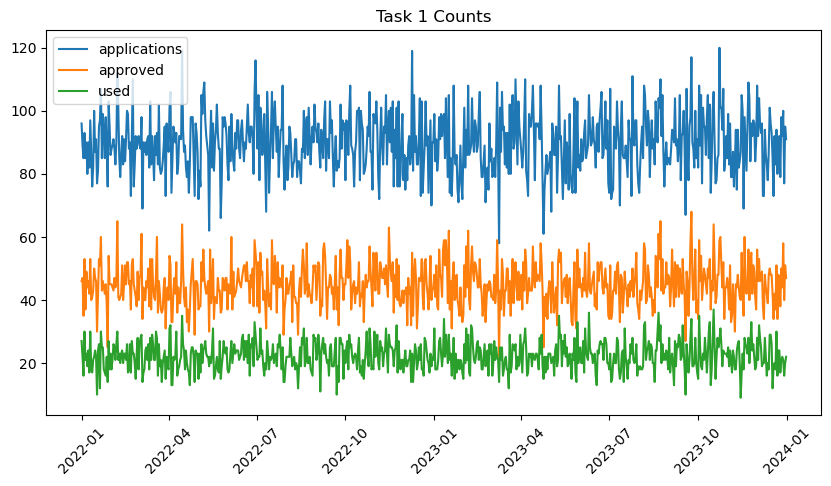

In [4]:
plt.figure(figsize=(10,5))
plt.plot(daily[submission_col], daily['num_applications'], label='applications')
plt.plot(daily[submission_col], daily['num_approved'], label='approved')
plt.plot(daily[submission_col], daily['num_used'], label='used')
plt.legend(); plt.xticks(rotation=45); plt.title("Task 1 Counts")
plt.show()

## Task 2 – Average Amounts

In [5]:
daily_amt = df.groupby(df[submission_col].dt.date).agg(
    avg_approved=('_approved_amount','mean'),
    avg_used=('_used_amount','mean')
).reset_index()

daily_amt

,submit_date,avg_approved,avg_used
0,2022-01-01,0.479167,439.145833
1,2022-01-02,0.528090,428.213483
2,2022-01-03,0.411765,323.882353
3,2022-01-04,0.569892,599.387097
4,2022-01-05,0.435294,345.552941
...,...,...,...
725,2023-12-27,0.478261,457.000000
726,2023-12-28,0.580000,308.360000
727,2023-12-29,0.519481,351.545455
728,2023-12-30,0.536842,361.452632


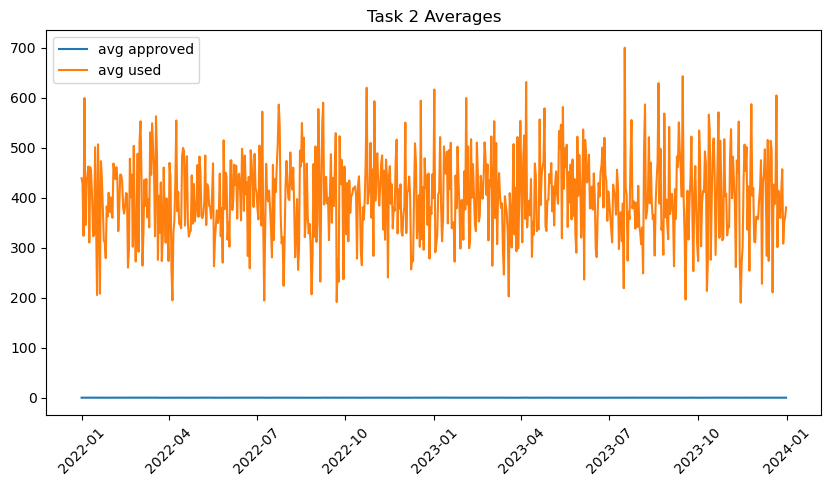

In [6]:
plt.figure(figsize=(10,5))
plt.plot(daily_amt[submission_col], daily_amt['avg_approved'], label='avg approved')
plt.plot(daily_amt[submission_col], daily_amt['avg_used'], label='avg used')
plt.legend(); plt.xticks(rotation=45); plt.title("Task 2 Averages")
plt.show()

## Task 3 – Metrics by Store

In [7]:
by_store = df.groupby(store_col).agg(
    num_apps=(submission_col,'count'),
    num_approved=('_approved_flag','sum'),
    approved_amt=('_approved_amount','sum'),
    num_used=('_used_flag','sum'),
    used_amt=('_used_amount','sum')
).reset_index()

by_store

,store,num_apps,num_approved,approved_amt,num_used,used_amt
0,store_0,284,146,146,69,107970.0
1,store_1,277,136,136,70,114715.0
2,store_10,253,128,128,60,94609.0
3,store_100,257,134,134,63,100645.0
4,store_101,257,130,130,63,107608.0
...,...,...,...,...,...,...
245,store_95,277,141,141,77,128846.0
246,store_96,282,137,137,70,121412.0
247,store_97,240,114,114,60,104116.0
248,store_98,260,114,114,50,85905.0


## Task 4 – Compare Used vs Spend by Marketing

In [8]:
customers = pd.read_excel(xls, sheet_name="customers")

df = df.merge(
    customers[['customer_id', 'campaign_id']],
    on='customer_id',
    how='left'
)

marketing_col = 'campaign_id'

In [14]:
by_marketing = df.groupby('campaign_id').agg(
    used_amt=('_used_amount', 'sum'),
    spend_amt=('_approved_amount', 'sum')
).reset_index()

In [15]:
if marketing_col:
    by_marketing = df.groupby(marketing_col).agg(
        used_amt=('_used_amount','sum'),
        spend_amt=('_approved_amount','sum')
    ).reset_index()
else:
    by_marketing = pd.DataFrame()

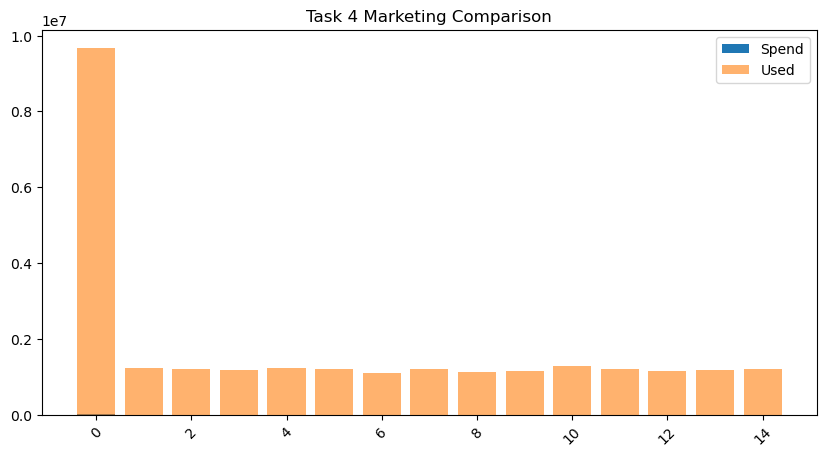

In [16]:
if marketing_col:
    plt.figure(figsize=(10,5))
    plt.bar(by_marketing[marketing_col], by_marketing['spend_amt'], label='Spend')
    plt.bar(by_marketing[marketing_col], by_marketing['used_amt'], label='Used', alpha=0.6)
    plt.xticks(rotation=45)
    plt.legend(); plt.title("Task 4 Marketing Comparison")
    plt.show()

## Task 5 – Interesting Insight: ROI

In [17]:
if marketing_col:
    by_marketing['roi_used_over_spend'] = by_marketing.apply(
        lambda r: r['used_amt']/r['spend_amt'] if r['spend_amt']>0 else None, axis=1)
    by_marketing.sort_values('roi_used_over_spend', ascending=False).head()
